# Automatic Forecasting with TempEst-NEXT

This Notebook automatically generates forecasts out to 17 days for a specified watershed.  It will eventually include three approaches:

1. Pour point forecast: one watershed.
2. Nested forecast: the whole upstream system at kilometer resolution, run as tightly-nested lumped models.
3. Interpolated forecast: the whole upstream system, using kilometer-scale smart interpolation or a reach model between confluences.

For convenience, it is assumed that the downstream point is a USGS gage.  However, NEXT's automatic data retrieval tools can work with coordinates as well, with no gage required.

We will set up the watershed model based on 5 years of daymet data (2018-2022), then run the next 17 days with GFS data (as well as the preceding several days, to get a correct rolling anomaly for the first few days of forecast).

# Setup and Watershed Identification

ERROR 1: PROJ: proj_create_from_database: Open of /u/wy/ch/dphilippus/.conda/envs/next/share/proj failed


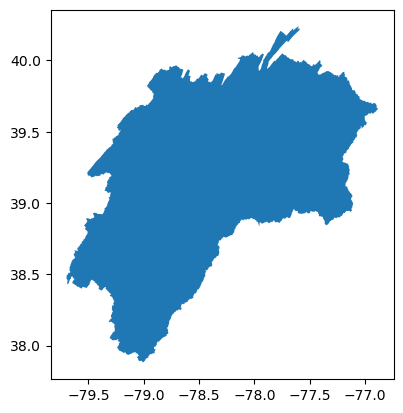

In [1]:
import NEXT
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import datetime
import dataretrieval.nwis as nwis
from pynhd import NLDI
from time import time
from NEXT.scripts.area_forecast import expand_line, expand_lines, run_forecasts, run_forecast, prepare_model, forecast_inputs
import seaborn as sns
# USGS gage as downstream location
# site = "10343500"    # Sagehen Creek nr Truckee, CA.  Small mountain watershed in Eastern Sierra.
site = "01646500"    # Potomac R near Little Falls Pump Stn., DC.  Large river near AGU24.  Possibly skewed by discharges.
# site = "01638500"    # Potomac R. at Point of Rocks, MD.  A little upstream to avoid the alteration.
# site = "01651827"    # Anacostia R., the watershed AGU is actually in
(ws, lat, lon, area) = NEXT.data.gage_geom(site)
ws.plot()
model = NEXT.NEXT.from_pickle("coefs.pickle")  # prepare a coefficient estimation model
nldi = NLDI()
basepath = "/scratch/dphilippus/notebooks/forecast/"
gribs = "/scratch/dphilippus/gfs/"

# Pour Point Forecast

We are assuming the pour point is a USGS gage (which is not necessary).  If it has stream temperature, we can come back later and check our forecasts.

## Forecast

In [9]:
# site = "-120.2379793:39.43157246"  # used for demo with coordinates
# model = NEXT.NEXT.from_pickle("coefs.pickle")
forecast = run_forecast(model, site, basepath, gribs)
forecast

,id,lat,lon,date,actemp,anom,temp.mod
0,01646500,38.949778,-77.127639,2024-11-25,9.224598,0.025041,9.249639
1,01646500,38.949778,-77.127639,2024-11-26,9.054266,0.048785,9.103052
2,01646500,38.949778,-77.127639,2024-11-27,8.885575,0.114612,9.000187
3,01646500,38.949778,-77.127639,2024-11-28,8.718574,0.064709,8.783283
4,01646500,38.949778,-77.127639,2024-11-29,8.553313,-0.231710,8.321603
5,01646500,38.949778,-77.127639,2024-11-30,8.389841,-1.411112,6.978729
6,01646500,38.949778,-77.127639,2024-12-01,8.228206,-1.411112,6.817094
7,01646500,38.949778,-77.127639,2024-12-02,8.068456,-1.663742,6.404714
8,01646500,38.949778,-77.127639,2024-12-03,7.910638,-2.314263,5.596376
9,01646500,38.949778,-77.127639,2024-12-04,7.754800,-2.092000,5.662801


<Axes: xlabel='date'>

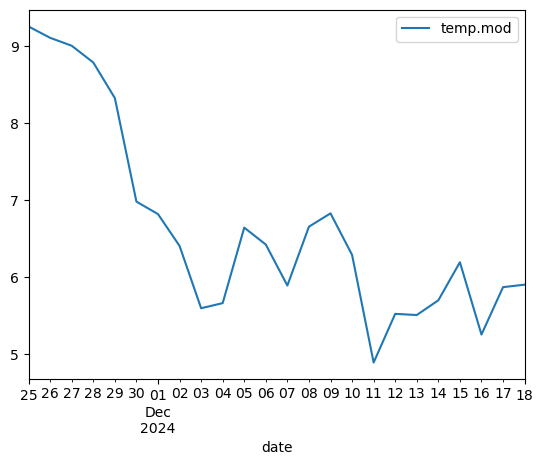

In [10]:
# Plot the forecast
forecast.plot(x="date", y="temp.mod", layout="compressed")

## Validation

To validate a forecast, specify the date it was run on.  The notebook will retrieve river temperature observations and evaluate performance.

In [35]:
dayrun = "2024-11-21"
file = "site_cache/" + f"forecast_{site}_{dayrun}.csv"
forecast = pd.read_csv(file, parse_dates=["date"])
first_day = forecast["date"].min().strftime("%Y-%m-%d")
last_day = forecast["date"].max().strftime("%Y-%m-%d")
obs = nwis.get_dv(sites=[site], start=first_day, end=last_day, parameterCd="00010")[0]["00010_Mean"].reset_index().rename(columns={"datetime": "date", "00010_Mean": "temperature"})
obs["date"] = obs["date"].dt.tz_localize(None)
data = forecast.merge(obs, how="left", on="date")
data

,id,date,actemp,anom,temp.mod,temperature
0,10343500,2024-11-15,7.602318,-0.060912,7.541406,3.4
1,10343500,2024-11-16,7.512555,-0.155425,7.357130,2.5
2,10343500,2024-11-17,7.423337,-0.189921,7.233416,2.9
3,10343500,2024-11-18,7.334689,-0.304972,7.029717,3.0
4,10343500,2024-11-19,7.246640,-0.664025,6.582615,2.0
5,10343500,2024-11-20,7.159214,-1.512100,5.647114,2.4
6,10343500,2024-11-21,7.072438,-1.512100,5.560338,2.2
7,10343500,2024-11-22,6.986337,-1.472646,5.513691,2.7
8,10343500,2024-11-23,6.900937,-1.239124,5.661814,2.5
9,10343500,2024-11-24,6.816264,-1.525103,5.291161,2.5


In [38]:
(data["temp.mod"] - data["temperature"]).mean()

3.307423476923174

<Axes: xlabel='date'>

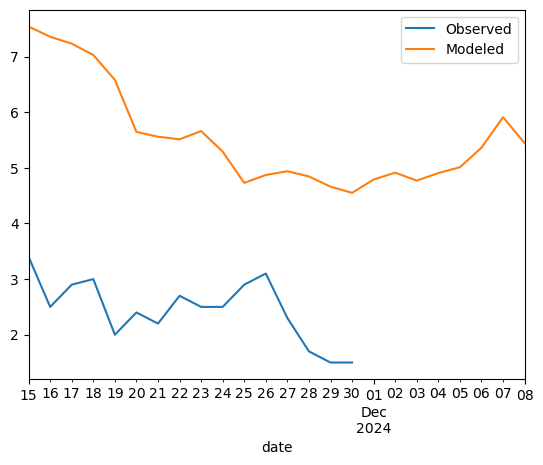

In [39]:
ax = data.plot(x="date", y="temperature", label="Observed")
data.plot(x="date", y="temp.mod", label="Modeled", ax=ax)

# Tightly Nested Watersheds

One approach to high-resolution modeling is to simply run a full, lumped watershed for each kilometer of river.  This is rather inefficient, since it involves a lot of redundant data retrieval, but it is straightforward because it can be run with only a lumped model.  It also serves to test the stability of model predictions in space.  The bulk of the analysis here is creating subwatersheds; after that, we simply run lumped models as per usual.

Since this isn't a good standard approach to high-resolution modeling, the watershed splicing is not built in to NEXT.

Kilometer spacing is not exact, since NHD+ spacing varies, but it is guaranteed to be less than 0.015 degrees, which is about 1.5 km in latitude and less (latitude-dependent) in longitude.

An alternative approach is to just interpolate along each linestring, instead of recursing.

## Set Up Coordinates

In [2]:
(ws, lat, lon, area) = NEXT.data.gage_geom(site)
coords = (lon, lat)
# resolution = 0.01  # 0.01 degrees is ~1.1 km latitude, ~0.9 km longitude
resolution = 0.01

In [3]:
def expand_line(line):
    count = line.length / resolution
    if count < 0.5:
        steps = []   # we don't want super-dense points on very short reaches
    elif count < 1.5:
        steps = [line.length]  # just the bottom
    else:
        steps = np.arange(resolution, line.length, resolution)
    return gpd.GeoSeries(line.interpolate(steps))

def expand_lines(geometry):
    return pd.concat([expand_line(g) for g in geometry])

<Axes: >

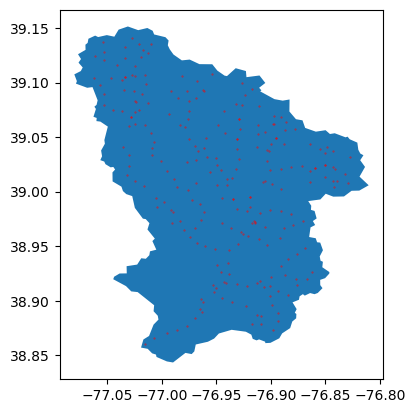

In [4]:
lines = nldi.navigate_byloc(coords, "upstreamTributaries", source="flowlines", distance=1000)
points = expand_lines(lines.geometry)
ax = ws.plot()
points.plot(ax=ax, c="red", markersize=0.1)

In [5]:
clist = [pt.coords[0] for pt in points]
print(len(clist))
clist[:5]

247


[(-77.00715167244856, 38.86599994706654),
 (-77.01503713038744, 38.86016550191219),
 (-76.97714217201427, 38.877012286542374),
 (-76.98648207671934, 38.87351581038549),
 (-76.99555285363746, 38.87020893756786)]

## Prepare Forecasts

To do this in many HPC runs, do the following.  Statics files start appearing after about 1 minute.  I recommend running GFS retrieval first, to make sure it goes through properly - things can get a bit weird when several jobs try to do it at once.  A full day's GFS NetCDF should be a little over 500 MB if it ran correctly.  Preparing the NetCDF takes a few minutes.  (Note this only needs to be run once per day - across all watersheds - since it retrieves data globally.)

In [3]:
print(f"python scripts/area_forecast.py {site} {basepath} [index] [Npartitions] 0.01 1000")

python scripts/area_forecast.py 01646500 /scratch/dphilippus/notebooks/forecast/ [index] [Npartitions] 0.01 1000


In [7]:
# help(NEXT.wforecast.get_gfs_downloaded)
NEXT.wforecast.get_gfs_downloaded(ws, "20241128", gribs)  # 6 days ago, too
NEXT.wforecast.get_gfs_downloaded(ws, "today", gribs)

date
2024-12-04     5.505252
2024-12-05     5.914053
2024-12-06     0.384189
2024-12-07     2.666690
2024-12-08    11.592243
2024-12-09    10.606317
2024-12-10    17.680135
2024-12-11    16.504624
2024-12-12    17.277332
2024-12-13     6.045067
2024-12-14     7.232347
2024-12-15     5.548213
2024-12-16    11.142058
2024-12-17    11.131639
2024-12-18    15.771438
2024-12-19    10.562048
2024-12-20     6.960432
Name: tmax, dtype: float64

While we're at it, let's see how long this takes.

- Sagehen (19 points):
    - With full data retrieval: Approx. 1 hour, 3 min/ws.
    - With forecast retrieval only: ~instantaneous (2 seconds)
    - Without (modeling only): ~instantaneous
- Potomac (19,000 points, total area 27,000 km2) (10-km: 600 points)
    - With full data retrieval: 20-30 seconds per watershed.  If that's sustained, we can expect approx. 160 core-hours for a 1-km forecast.
    - With forecast retrieval only: ~2 seconds per watershed
    - Modeling only: 

In [2]:
def wrapper(op, start, crash=False, retry=True):
    try:
        result = op()
        delta = (time() - start) / 60
        print(f"\r{delta:08.2f}", end="")
        return result
    except Exception as e:
        if crash:
            raise e
        if retry:  # retry once
            return wrapper(op, start, crash, False)
        return None
fcst_run = run_forecasts(site, "coefs.pickle", basepath, gribs, 0.1, 1000)
start = time()
forecast_list = [
    wrapper(
        op,
        start,
        crash=True
    )
    for op in fcst_run
]
forecast = pd.concat(forecast_list)
runtime = (time() - start) / 3600
print(f"\rTook {runtime:.2f} hours")

00006.93


KeyboardInterrupt



## Load Existing Forecasts

They all go in the same place, so it's necessary to filter for the correct location.  For example, the Potomac sites are east of -80 longitude, while the Sagehen sites are well to the west.

Tracking:

Note that large numbers of jobs, e.g. 20, don't work well.  Daymet bandwidth?  Also, runs that keep going through midnight tend to generate prepared data but not actual forecasts, since the forecast retrieval can have issues.  Generating forecasts alone with prepared data is about 2,000 sites per job per hour.

- 129 sites at 16:56 on 12/1, currently using 2 jobs.
- Restarting with 238 at 17:38, using 5 jobs. 242 at 17:43 when it really picked up.
- 2,464 at 07:35 on 12/2, 0.5 s/j/m (2187/4110).  Should be a total of 630 core-hours or 580 remaining.
- Still 2,464 restarting at 12:09 on 12/2.  Note that a new run on the next day starts by re-running a ton of forecasts.  In this initial run, it generates approx. 100 forecasts per minute with 5 jobs (3 sec/forecast).
- 6506 at 13:15.  I think it has reverted to actual processing now.
- 7052 at 14:57.  1 w/j/m (546/510).  This rate has been quite stable over several check-ins.
- Started 9:42 on 12/3 with 10071 previously generated and 0 for 12/3.  It took about an hour to catch up.
- 12/3: 10100 at 10:41.
- 10176 at 10:48, 2 w/j/m (76/35).  Some of the jobs are probably still catching up.
- 10501 at 11:45, >1 w/j/m (325/285).  Holding at a little over 1.
- 10998 at 13:05, >1 w/j/m.
- 11518 at 14:34, >1 w/j/m.
- 12443 from 12/03 when starting at 10:25 on 12/04, plus some extra statics-only.  Caught up at 11:36. 12531 at 11:39, stabilized.
- 13547 at 14:27.  Holding steady at 1.2 w/j/m.

In [9]:
fcst_files = [basepath + f for f in os.listdir(basepath) if f.startswith("forecast_-7") and "2024-12-04" in f]
forecast = pd.concat([pd.read_csv(f, parse_dates=["date"]) for f in fcst_files])
forecast

,id,lat,lon,date,actemp,anom,temp.mod
0,-77.68192444884397:39.58559481290807,39.585595,-77.681924,2024-11-28,8.106940,-0.014199,8.092740
1,-77.68192444884397:39.58559481290807,39.585595,-77.681924,2024-11-29,7.959848,-0.077794,7.882054
2,-77.68192444884397:39.58559481290807,39.585595,-77.681924,2024-11-30,7.814348,-0.241559,7.572789
3,-77.68192444884397:39.58559481290807,39.585595,-77.681924,2024-12-01,7.670483,-0.600858,7.069625
4,-77.68192444884397:39.58559481290807,39.585595,-77.681924,2024-12-02,7.528296,-1.440117,6.088179
...,...,...,...,...,...,...,...
19,-77.5781596564773:39.78636458421923,39.786365,-77.578160,2024-12-17,4.876792,0.343023,5.219815
20,-77.5781596564773:39.78636458421923,39.786365,-77.578160,2024-12-18,4.769212,1.190945,5.960157
21,-77.5781596564773:39.78636458421923,39.786365,-77.578160,2024-12-19,4.663899,2.086814,6.750713
22,-77.5781596564773:39.78636458421923,39.786365,-77.578160,2024-12-20,4.560883,1.863096,6.423979


In [10]:
len(forecast["id"].unique())

13218

## Plot Forecasts

Trends tend to be fairly similar (though varying in magnitude) within an area, since the region is affected by similar weather fronts.

We can also plot a single day, or animate it.

The timeseries plot gets unreasonably slow at several tens of thousands of rows, so I recommend against running it for large watersheds.

In [ ]:
ax = sns.scatterplot(forecast, x="date", y="temp.mod")
ax.legend().remove()
ax.set_xlabel("Date")
ax.set_ylabel("Forecast Mean Daily Temperature (C)")
ax.set_title("Potomac Watershed Points")
ax.tick_params(axis='x', rotation=45)

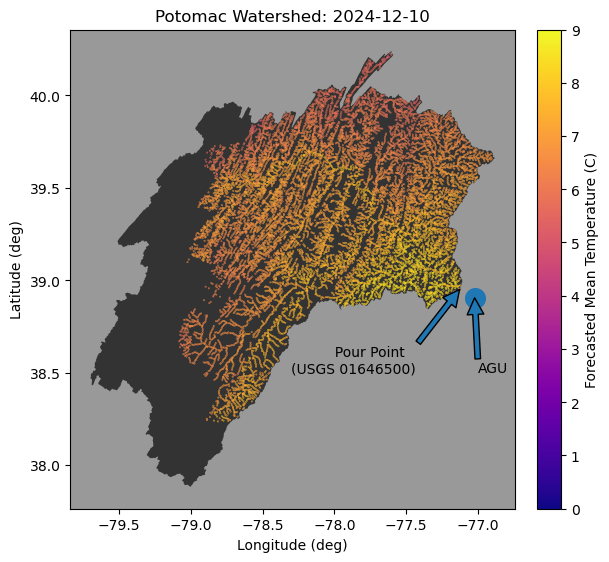

In [11]:
fig = plt.figure(figsize=(6, 6), layout="compressed")
ax = plt.axes(facecolor="#999")
dat = forecast[forecast["date"] == "2024-12-10"]
ws.plot(ax=ax, color="#333")
dat.plot.scatter(x="lon", y="lat", c="temp.mod", s=0.1, title="Potomac Watershed: 2024-12-10", ax=ax, colormap="plasma", vmin=0, vmax=int(dat["temp.mod"].max()) + 1)
# DC convention center
dcx = -77.02299677632044
dcy = 38.90490577636493
ax.scatter(x=dcx, y=dcy, s=200)
ax.annotate("AGU", (dcx, dcy), xytext=(-77, 38.5), arrowprops={})
ax.annotate(f"          Pour Point\n(USGS {site})", (lon, lat),
            xytext=(-78.3, 38.5), arrowprops={})
ax.collections[1].colorbar.set_label("Forecasted Mean Temperature (C)")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
plt.savefig("figures/Potomac_20241210.png", dpi=300)

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(facecolor="#999")
dates = np.array(forecast["date"].unique(), dtype='datetime64[D]')
# We don't want to run the spinup time, since the anomaly is inaccurate
dates = dates[dates >= np.datetime64("2024-12-01")]
dates.sort()
def animate(i):
    date = dates[i]
    fig.clear()
    ax = plt.axes(facecolor="#999")
    ws.plot(ax=ax, color="#333")
    forecast[forecast["date"] == date].plot.scatter(x="lon", y="lat", c="temp.mod", title=str(date), ax=ax, colormap="plasma", vmin=0, vmax=int(forecast["temp.mod"].max()) + 1, s=0.1)
    ax.collections[1].colorbar.set_label("Forecasted Mean Temperature (C)")
    ax.set_xlabel("Longitude (deg)")
    ax.set_ylabel("Latitude (deg)")
    plt.tight_layout()

a = anim.FuncAnimation(fig, animate, interval=500, frames=range(len(dates)))
a.save(f"forecast_anims/{site}_forecast.gif")